# Using Siamese Networks to recommend similar clothing 
We are trying to learn the embedding of images in order to learn the visual similarity. Finding products that looks similar to a particular product is an important feature for a e-commerce platforms. We will be trying this on a image dataset that contains cropped tops


Ref Papers:
<br> https://arxiv.org/pdf/1901.03546v1.pdf
<br> Ref Articles: 
<br> https://towardsdatascience.com/retrieving-similar-e-commerce-images-using-deep-learning-6d43ed05f46b
<br> https://medium.com/vitrox-publication/understanding-circle-loss-bdaa576312f7
<br> https://towardsdatascience.com/the-w3h-of-alexnet-vggnet-resnet-and-inception-7baaaecccc96
<br> https://keras.io/examples/vision/siamese_network/
<br> Ref Code: 
<br> https://colab.research.google.com/drive/175Ish76RqC4n5X_net4An3cqqANM3DzZ#scrollTo=9wjZn-QHjZ7q

# Data
Cloud storage contains clothing images that have been marked triplets by the author. <br> https://console.cloud.google.com/storage/browser/fynd-open-source/research/MILDNet 

### Mounting Google Drive which contains our data

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /gdrive

Mounted at /content/drive
[Errno 2] No such file or directory: '/gdrive'
/content


### Importing dependencies

In [2]:
#!pip install tensorflow_addons

     |████████████████████████████████| 679 kB 7.8 MB/s 


In [59]:
import os
import cv2
import json
import time
import random
import csv
import requests
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import numpy as np


from PIL import Image
from keras import backend as K 
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications import resnet
from tensorflow.keras.layers import Dropout, Flatten, Dense, Input, MaxPool2D, GlobalAveragePooling2D, Lambda, Conv2D, concatenate, ZeroPadding2D, Layer, MaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow import keras
from sklearn.decomposition import PCA
from random import shuffle
from tqdm import tqdm

### Copying the zip folder to content and then unzipping

In [4]:
!cp '/content/drive/My Drive/Colab Tops/research_MILDNet_tops_cropped.zip' '/content/'

In [24]:
!unzip '/content/research_MILDNet_tops_cropped.zip'


Streaming output truncated to the last 5000 lines.
  inflating: tops_cropped/77096.jpg  
  inflating: tops_cropped/359501.jpg  
  inflating: tops_cropped/52605.jpg  
  inflating: tops_cropped/382999.jpg  
  inflating: tops_cropped/274873.jpg  
  inflating: tops_cropped/289072.jpg  
  inflating: tops_cropped/203029.jpg  
  inflating: tops_cropped/390522.jpg  
  inflating: tops_cropped/348798.jpg  
  inflating: tops_cropped/7870.jpg   
  inflating: tops_cropped/238276.jpg  
  inflating: tops_cropped/46680.jpg  
  inflating: tops_cropped/189723.jpg  
  inflating: tops_cropped/387827.jpg  
  inflating: tops_cropped/18785.jpg  
  inflating: tops_cropped/420665.jpg  
  inflating: tops_cropped/200983.jpg  
  inflating: tops_cropped/47601.jpg  
  inflating: tops_cropped/246926.jpg  
  inflating: tops_cropped/377163.jpg  
  inflating: tops_cropped/266268.jpg  
  inflating: tops_cropped/292368.jpg  
  inflating: tops_cropped/399316.jpg  
  inflating: tops_cropped/304601.jpg  
  inflating: tops_c

<h3> Examining some of our images</h3>

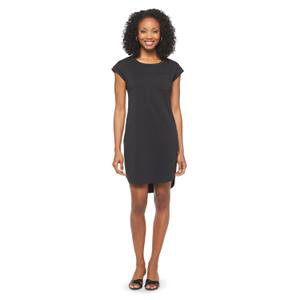

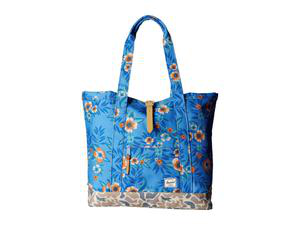

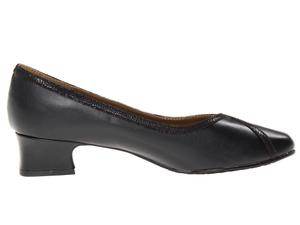

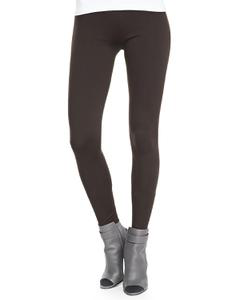

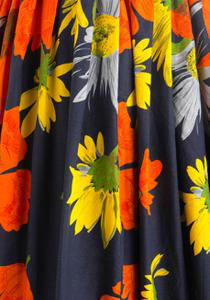

In [25]:
clothing = ['tops_cropped/344448.jpg', 'tops_cropped/184831.jpg', 'tops_cropped/190040.jpg', 'tops_cropped/202668.jpg', 'tops_cropped/65124.jpg'] 

for item in clothing:
  image = Image.open(item)
  display(image)

Our dataset contains fashion clothing

<h3> Data Ingestion </h3>

Since our images our uploaded to the 'content/tops_cropped' we need to ensure we have the correct location, and that in our pipeline we will ingest the anchor, positive and negative images correctly. Lucikly our dataset has associated csv's that link anchor, positive and negative images together.

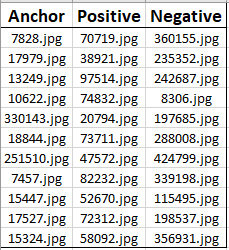

In [26]:
# Gets the image path for each of triplet

img_path = 'tops_cropped/'

def get_image_path(path):
  ''' This function takes the path of the csv file as input and returns a list where each element of the list contains a triplet with the path where the actual image is present.'''
  data_path_lst = []
  
  global img_path 
  with open(path) as csv_file:
    data = csv.reader(csv_file, delimiter = ',')
    for row in data:
      data_path_lst.append([img_path + row[0], img_path + row[1], img_path + row[2]])

  return data_path_lst

In [27]:
# returning processed image files for the anchor, positive, and negative images

def input_parser(input_tensor):
  
  ''' This function is used as part of data pipeline which reads image path as part of data.Dataset and generate 
  img1(output): containing final tensor for anchor images
  img2(output): containing final tensor for positive images
  img3(output): containing final tensor for negative images'''

  img1 = tf.image.resize(tf.image.decode_jpeg(tf.io.read_file(input_tensor[0]), channels=3), [224, 224])
  img2 = tf.image.resize(tf.image.decode_jpeg(tf.io.read_file(input_tensor[1]), channels=3), [224, 224])
  img3 = tf.image.resize(tf.image.decode_jpeg(tf.io.read_file(input_tensor[2]), channels=3), [224, 224])

  return img1, img2, img3

In [28]:
# returning processed image files for the anchor, positive, and negative images returns a tensorflow.python.data.ops.dataset_ops object

def input_pipeline(data_path, shuffle_size, batch_size):
  '''
  This function takes in data_path and the batch_size and return final tensors representing each of the image.
  data_path(input): final list which contains triplet details for input pipeline
  batch_size(input): number of records for each step
  dataset(output): final dataset object containing tensor of images with a fixed batch size
  '''
  with tf.device('/cpu:0'):
    dataset = tf.data.Dataset.from_tensor_slices((np.array((data_path))))
    dataset = dataset.shuffle(shuffle_size)
    dataset = dataset.map(input_parser, num_parallel_calls = tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size).repeat()
    dataset = dataset.prefetch(1)

  return dataset

By using take we are able to see that our pipeline correctly built the anchor, positive, and negative image flow

<h3> Our Siamese model </h3>

In [29]:
# Our target shape will be (224, 224)
target_shape = (224, 224)

base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False)

flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(512, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(256)(dense2)

embedding = Model(base_cnn.input, output, name="Embedding")

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

In [125]:
# Our target shape will be (224, 224)
def model_architecture():
  target_shape = (224, 224)

  base_cnn = resnet.ResNet50(
      weights="imagenet", input_shape=target_shape + (3,), include_top=False)

  flatten = layers.Flatten()(base_cnn.output)
  dense1 = layers.Dense(512, activation="relu")(flatten)
  dense1 = layers.BatchNormalization()(dense1)
  dense2 = layers.Dense(256, activation="relu")(dense1)
  dense2 = layers.BatchNormalization()(dense2)
  output = layers.Dense(256)(dense2)

  embedding = Model(base_cnn.input, output, name="Embedding")

  trainable = False
  for layer in base_cnn.layers:
      if layer.name == "conv5_block1_out":
          trainable = True
      layer.trainable = trainable

  return embedding

Our Siamese Network will generate embeddings for each of the images of the triplet. To do this, we will use a ResNet50 model pretrained on ImageNet and connect a few Dense layers to it so we can learn to separate these embeddings. <br> - As seen in the Keras documentation https://keras.io/examples/vision/siamese_network/ <br> More on Resnet50 - https://arxiv.org/pdf/1512.03385.pdf <br> http://ethereon.github.io/netscope/#%2Fgist%2Fdb945b393d40bfa26006
.

In [30]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)

In [164]:
anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(negative_input)),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)


In [44]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]


In [45]:
#define path from where data will be read
train_csv_file = '/content/drive/My Drive/Colab Tops/tops_train.csv'
cv_csv_file = '/content/drive/My Drive/Colab Tops/tops_val.csv'
val_batch_size = 128

#calling get_image_path to get a list of triplets with actual path
train_data_path = get_image_path(train_csv_file)
validation_data_path = get_image_path(cv_csv_file)

<h3> Training our model </h3>

In [33]:
train_dataset = input_pipeline(train_data_path, len(train_data_path), 32) # calling pipeline method to generate train dataset
#validation_dataset = input_pipeline(validation_data_path, len(validation_data_path), 32) # calling pipeline method to generate validation dataset

In [128]:
K.clear_session()

In [166]:
# Saving our model
checkpoint_path = "/content/drive/MyDrive/Colab Tops/training/siameseweights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
#cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                 save_weights_only=True,
#                                                 verbose=1)

# Executing our model
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.0001))
siamese_model.fit(train_dataset, epochs=10, steps_per_epoch=20)
siamese_model.save_weights(checkpoint_path)

Epoch 1/10
20/20 [==============================] - 13s 247ms/step - loss: 0.0711
Epoch 2/10
20/20 [==============================] - 6s 288ms/step - loss: 0.0562
Epoch 3/10
20/20 [==============================] - 5s 266ms/step - loss: 0.0356
Epoch 4/10
20/20 [==============================] - 5s 226ms/step - loss: 0.0412
Epoch 5/10
20/20 [==============================] - 5s 265ms/step - loss: 0.0428
Epoch 6/10
20/20 [==============================] - 5s 241ms/step - loss: 0.0503
Epoch 7/10
20/20 [==============================] - 4s 198ms/step - loss: 0.0436
Epoch 8/10
20/20 [==============================] - 4s 198ms/step - loss: 0.0523
Epoch 9/10
20/20 [==============================] - 5s 238ms/step - loss: 0.0368
Epoch 10/10
20/20 [==============================] - 6s 295ms/step - loss: 0.0398


In [76]:
sample = next(iter(train_dataset))

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(resnet.preprocess_input(anchor)),
    embedding(resnet.preprocess_input(positive)),
    embedding(resnet.preprocess_input(negative)),
)

Using Cosine Similarity to see how close the embeddings are

In [77]:
cosine_similarity = metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())


Positive similarity: 0.31956887
Negative similarity 0.1733361


The positive cases are much closer together than the negative ones! Which is exactly what we wanted.

# Generating similar images 

#### Slightly different more advanced model <br> model from https://towardsdatascience.com/retrieving-similar-e-commerce-images-using-deep-learning-6d43ed05f46b

In [177]:
def model_architecture():
  '''
  Ref: https://github.com/gofynd/mildnet/blob/master/trainer/model.py
  This function contains model architecture which will be used to generate final embedding for each image.
  model(output): Final model object
  '''
  pre_trained_model = VGG19(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
  convnet = GlobalAveragePooling2D()(pre_trained_model.output)
  convnet = Dense(4096, activation = 'relu')(convnet)
  convnet = Dropout(0.5)(convnet)
  convnet = Dense(4096, activation = 'relu')(convnet)
  convnet = Dropout(0.5)(convnet)
  convnet = Lambda(lambda x : K.l2_normalize(x, axis = 1))(convnet)

  s1_inp = Input(shape = (224, 224, 3))
  s1 = MaxPool2D(pool_size = (4, 4), strides = (4, 4), padding = 'valid')(s1_inp)
  s1 = ZeroPadding2D(padding = (4, 4), data_format = None)(s1)
  s1 = Conv2D(96, kernel_size = (8, 8), strides = (4, 4), padding = 'valid')(s1)
  s1 = ZeroPadding2D(padding = (2, 2), data_format = None)(s1)
  s1 = MaxPool2D(pool_size = (7, 7), strides = (4, 4), padding = 'valid')(s1)
  s1 = Flatten()(s1)

  s2_inp = Input(shape = (224, 224, 3))
  s2 = MaxPool2D(pool_size = (8, 8), strides = (8, 8), padding = 'valid')(s2_inp)
  s2 = ZeroPadding2D(padding = (4, 4), data_format = None)(s2)
  s2 = Conv2D(96, kernel_size = (8, 8), strides = (4, 4), padding = 'valid')(s2)
  s2 = ZeroPadding2D(padding = (1, 1), data_format = None)(s2)
  s2 = MaxPool2D(pool_size = (3, 3), strides = (2, 2), padding = 'valid')(s2)
  s2 = Flatten()(s2)

  merge = concatenate([s1, s2])
  merge = Lambda(lambda x : K.l2_normalize(x, axis = 1))(merge)
  merge = concatenate([merge, convnet], axis = 1)
  embedding = Dense(4096)(merge)
  embedding = Lambda(lambda x : K.l2_normalize(x, axis = 1))(embedding)

  model = tf.keras.models.Model(inputs = [s1_inp, s2_inp, pre_trained_model.input], outputs = embedding)
  return model

This model comes from this paper - https://arxiv.org/pdf/1901.03546.pdf

In [130]:
def get_image_path(path):
  '''
  This function is used in our case to read the data that we have in our test set
  It will read the test csv file that we have, return 2 separate list, one with 
  query images and other with images that we already have in system.
  '''
  query_image = []
  pos_image = []
  neg_image = []
  
  global img_path 
  with open(path) as csv_file:
    data = csv.reader(csv_file, delimiter = ',')
    for row in data:
      query_image.append(img_path + row[0])
      pos_image.append(img_path + row[1])
      neg_image.append(img_path + row[2])
  all_images = pos_image + neg_image

  return query_image, list(set(all_images))

In [131]:
def query_embedding(query_image_path):
  '''
  This function returns image embedding for any query image based on the best model
  weights that are saved during training. 
  '''
  img = tf.image.resize(tf.image.decode_jpeg(tf.io.read_file(query_image_path), channels=3), [224, 224])
  img = tf.reshape(img, [1,224,224,3])
  return model((img, img, img))

In [132]:
def parser(input_tensor):
  '''
  This function can be used as a parser function for all the images we have that
  will be recommended to the user when the user will select a query image
  '''
  return tf.image.resize(tf.image.decode_jpeg(tf.io.read_file(input_tensor), channels=3), [224, 224])

In [133]:
def get_saved_images_embedding(data_path, batch_size = 128):
  '''
  This function is used to generate a pipeline that will be used to create a batch.
  Main purpose of having this is to overcome the RAM issue faced since we are using 
  everything on colab, in real world all our images will be stored in a bucket from where
  we can directly read them from their and pass on to model function to generate the 
  embedding which will be stored in a cache DB for low latency
  '''
  dataset = tf.data.Dataset.from_tensor_slices((np.array((data_path))))
  dataset = dataset.map(parser, num_parallel_calls = tf.data.experimental.AUTOTUNE)
  dataset = dataset.batch(batch_size)
  return dataset

In [178]:
#In these cells we are generating embedding for all images that we have
img_path = '/content/tops_cropped/'
query_lst, stored_images_list = get_image_path('/content/drive/My Drive/Colab Tops/tops_test.csv')

model = model_architecture() # calling model architecture function
model.load_weights('/content/drive/My Drive/Colab Tops/epoch4model.h5') # Loading weights for model saved after 4th epoch

saved_images_data = get_saved_images_embedding(stored_images_list)
test_iterator = iter(saved_images_data)

#generating embeddings
test_data_lst = []
for _ in tqdm(range(len(stored_images_list) // 128)):
  test_data = test_iterator.get_next()
  test_data_lst.append(model((test_data, test_data, test_data)))
final_embedding = tf.concat(test_data_lst, axis = 0)
del test_data_lst

80142336/80134624 [==============================] - 0s 0us/step


100%|██████████| 63/63 [00:31<00:00,  2.03it/s]


In [187]:
def cosine_distance(x, y):
  '''
  This function inputs 2 vector and calculates cosine distance.
  '''
  return np.dot(x, y)/(np.linalg.norm(x) * np.linalg.norm(y))


def get_image_path(path):
  '''
  This function is used in our case to read the data that we have in our test set
  It will read the test csv file that we have, return 2 separate list, one with 
  query images and other with images that we already have in system.
  '''
  query_image = []
  pos_image = []
  neg_image = []
  
  global img_path 
  with open(path) as csv_file:
    data = csv.reader(csv_file, delimiter = ',')
    for row in data:
      query_image.append(img_path + row[0])
      pos_image.append(img_path + row[1])
      neg_image.append(img_path + row[2])
  all_images = pos_image + neg_image

  return query_image, list(set(all_images))

In [186]:
def get_neighbours(train, query_embedding, k):
  '''
  This function finds the NN based on the cosine distance, it return top k NNs
  '''
  distance = [(index, cosine_distance(row, query_embedding)) for index, row in enumerate(train)]
  distance.sort(key = lambda x : x[1], reverse=True)
  return distance[0:k]

In [ ]:
#For all the query images, generating 10 NN based on cosine similarity
nn_lst = []
for i in tqdm(range(len(query_lst))):
  nn_lst.append([(i, 1)] + get_neighbours(final_embedding, query_embedding(query_lst[i])[0], 10))




  0%|          | 0/7000 [00:00<?, ?it/s]


  0%|          | 1/7000 [00:02<4:24:24,  2.27s/it]


  0%|          | 2/7000 [00:04<4:24:11,  2.27s/it]


  0%|          | 3/7000 [00:06<4:25:42,  2.28s/it]


  0%|          | 4/7000 [00:09<4:25:36,  2.28s/it]


  0%|          | 5/7000 [00:11<4:22:32,  2.25s/it]


  0%|          | 6/7000 [00:13<4:24:38,  2.27s/it]


  0%|          | 7/7000 [00:15<4:25:18,  2.28s/it]


  0%|          | 8/7000 [00:18<4:25:49,  2.28s/it]


  0%|          | 9/7000 [00:20<4:24:58,  2.27s/it]


  0%|          | 10/7000 [00:22<4:29:04,  2.31s/it]


  0%|          | 11/7000 [00:25<4:34:27,  2.36s/it]


  0%|          | 12/7000 [00:27<4:38:56,  2.40s/it]


  0%|          | 13/7000 [00:30<4:42:28,  2.43s/it]


  0%|          | 14/7000 [00:32<4:44:57,  2.45s/it]


  0%|          | 15/7000 [00:35<4:46:21,  2.46s/it]


  0%|          | 16/7000 [00:37<4:46:59,  2.47s/it]


  0%|          | 17/7000 [00:40<4:47:54,  2.47s/it]


  0%|          | 18/7000 [00:42<4:49:36,  2.4

Viewing the closest 5 images

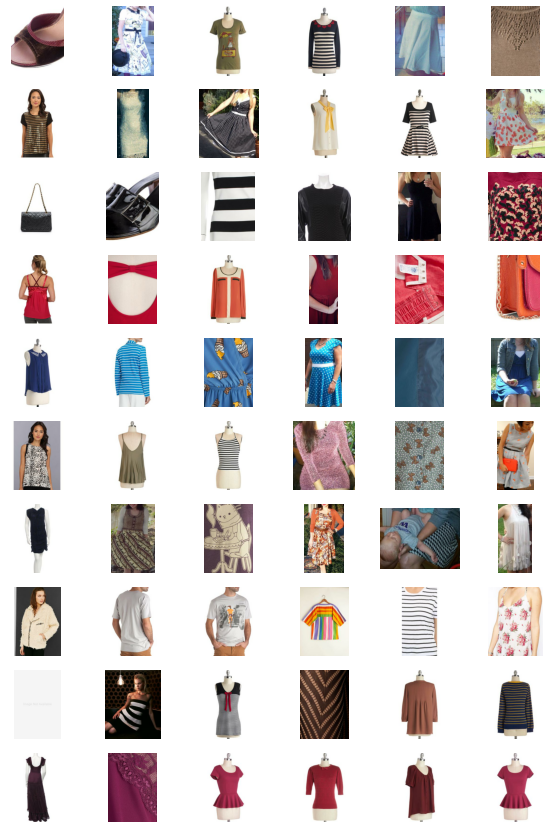

In [185]:
fig=plt.figure(figsize=(10, 15))
shuffle(nn_lst) # Shuffling list
subplot_index = 1 #Creating an index element for sub plots

for items in nn_lst[0:10]: #choosing 10 samples
  for index in range(6):
    img = tf.image.decode_jpeg(tf.io.read_file(stored_images_list[items[index][0]]), channels=3)
    fig.add_subplot(10, 6, subplot_index)
    plt.axis('off')
    plt.imshow(img)
    subplot_index += 1

plt.axis('off')
plt.show()
#First image is the query image and the next 5 images are the result model gave...

In [ ]:
fig=plt.figure(figsize=(10, 15))
shuffle(nn_lst)
subplot_index = 1
for items in nn_lst[0:10]:
  for index in range(6):
    img = tf.image.decode_jpeg(tf.io.read_file(stored_images_list[items[index][0]]), channels=3)
    fig.add_subplot(10, 6, subplot_index)
    plt.axis('off')
    plt.imshow(img)
    subplot_index += 1

plt.axis('off')
plt.show()